# Predicting the sale price of bulldozers using machine learning

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## 1. Problem Definition
> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data
Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well my model is doing, I'll calculate the RMSLE and then compare my results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means.

First, import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [13]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [15]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [16]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

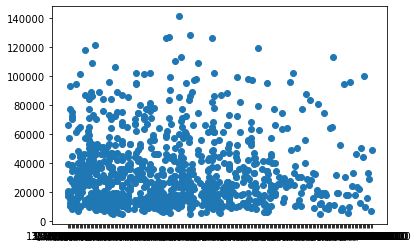

In [17]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

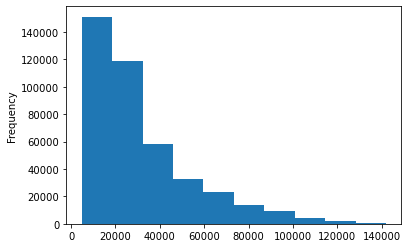

In [18]:
df.SalePrice.plot.hist();

### Parsing dates
When working with time series data, enrich the time and date components as much as possible

This can be achieved by using the `parse_dates` parameter

In [19]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

In [20]:
df["saledate"].dtype

dtype('O')

In [21]:
# Re import the data but now parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [22]:
df["saledate"].dtype

dtype('<M8[ns]')

In [23]:
df["saledate"][:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

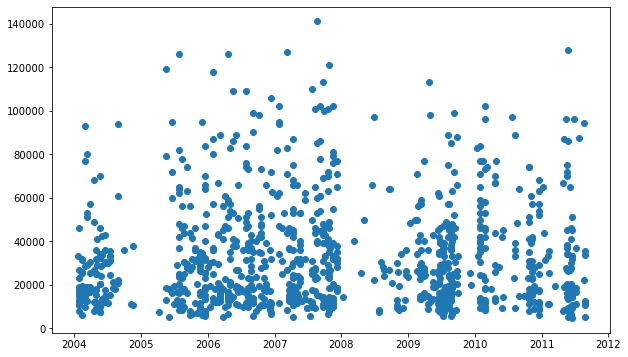

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

In [25]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [27]:
df.saledate.head(10)

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate
For time series data it is better to sort it by date

In [28]:
df.sort_values(by=["saledate"],ascending=True, inplace=True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

### make a copy of the original DataFrame

In [29]:
df_temp = df.copy()

In [30]:
df_temp.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for `saledate` column

In [31]:
df_temp[:2].saledate.dt.year

205615    1989
274835    1989
Name: saledate, dtype: int64

In [32]:
df_temp[:2].saledate.dt.month

205615    1
274835    1
Name: saledate, dtype: int64

In [33]:
df_temp["saleYear"] = df_temp.saledate.dt.year
df_temp["saleMonth"]= df_temp.saledate.dt.month
df_temp["saleDate"] = df_temp.saledate.dt.date
df_temp["saleDayOfWeek"] = df_temp.saledate.dt.dayofweek
df_temp["saleDayOfYear"] = df_temp.saledate.dt.dayofyear

In [34]:
df_temp.head(20).T;

In [35]:
### After enriching the DataFrame, remove the saledate


In [36]:
df_temp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

# 5. Modelling
Model driven EDA

In [37]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

### Turning data to numbers

### Convert strings to numbers
One way to convert data into numbers is to convert to  string categories

In [38]:
pd.api.types.is_string_dtype(df_temp["UsageBand"])

True

In [39]:
# Find the columns which contain strings
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [40]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 58 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   category      
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  category      
 11  fiBaseModel               412698 non-null  category      
 1

In [79]:
df_temp.state.cat.categories

AttributeError: Can only use .cat accessor with a 'category' dtype

In [42]:
df_temp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Can access data that was initially strings to numbers
But still missing values

In [43]:
# Check for missing values 
df_temp.isna().sum() / len(df_temp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

# Save Preprocessed Data

In [44]:
# Export current temp dataframe
df_temp.to_csv("data/bluebook-for-bulldozers/train_temp.csv", 
               index = False)

In [45]:
# Import the preprocessed data to confirm
df_temp = pd.read_csv("data/bluebook-for-bulldozers/train_temp.csv",
                     low_memory=False)
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17,1989-01-31,1989-01-31,1989-01-31,1989-01-31


In [46]:
df_temp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

## Fill missing values
### FIll numerical data first

In [47]:
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDate
saleDayOfWeek
saleDayOfYear


In [48]:
## Check for which numeric columns have missing values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [49]:
## Fill numeric rows with median
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_temp[label+"_is_missing"] = pd.isnull(content)
            # FIll missing values with median
            df_temp[label] = content.fillna(content.median())

In [50]:
## Check if there is any null numeric values left
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [51]:
# Check to see how many examples were missing
df_temp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [52]:
df_temp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
saledate                                    0
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                         

## FIll categorical values into numbers

In [53]:
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
saledate
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [76]:
## Turn categorical values into numbers and fill missing values
# Turn categorical variables into numbers
for label, content in df_temp.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_temp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_temp[label] = pd.Categorical(content).codes+1  

In [77]:
pd.Categorical(df_temp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [59]:
df_temp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 106, dtype: int64

In [60]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 106 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(47), float64(3), int64(10), int8(1), object(45)
memory usage: 201.5+ MB


In [61]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


## Build a machine learning model since all data is now numerical

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
len(df_temp)

412698

In [70]:
X = df_temp.drop("SalePrice", axis=1)
y = df_temp['SalePrice']

In [78]:
X.UsageBand.isna().sum()

339028

In [71]:
%%time

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
#Fit the model
model.fit(X,y)

ValueError: could not convert string to float: 'Low'